In [1]:
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization
import numpy as np
from six.moves import range

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters Config

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

# Data Generation

In [5]:
def gen_data(size, op, max_len, digits, reverse=False):
    if op not in '+-':
        raise Exception("Only supprt '+' and '-' operation")
    questions = []
    expected = []
    seen = set()
    while len(questions) < size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        if op == '-' and a < b:
            a, b = b, a
        q = '{}{}{}'.format(a, op, b)
        query = q + ' ' * (max_len - len(q))
        ans = str(eval(q))
        ans += ' ' * (digits + 1 - len(ans))
        if reverse:
            query = query[::-1]
        questions.append(query)
        expected.append(ans)
    return questions, expected

# Processing

In [6]:
def vectorization(questions, expected, ctable, max_len, digits):
    x = np.zeros((len(questions), max_len, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, max_len)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, digits + 1)
    return x, y

In [7]:
def train_test_split(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    split_at = len(y) - len(y)//10
    x_train = x[:split_at]
    y_train = y[:split_at]
    x_val = x[split_at:]
    y_val = y[split_at:]

    print('Training Data:')
    print(x_train.shape)
    print(y_train.shape)

    print('Testing Data:')
    print(x_val.shape)
    print(y_val.shape)

    return x_train, x_val, y_train, y_val

# Model defination

In [8]:
def build_model(hidden_size, max_len, digits, chars, rnn=layers.LSTM):
    print('Build model...')

    model = Sequential()
    model.add(rnn(hidden_size, input_shape=(max_len, len(chars))))    
    model.add(BatchNormalization())
    model.add(layers.RepeatVector(digits + 1))
    
    model.add(rnn(hidden_size, return_sequences=True))
    model.add(BatchNormalization())
    
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

### 嘗試在原始模型中，LSTM 垂直方向都加入 BatchNormalization，目測發現效果很不錯，尤其三種情況都明顯加速收斂速度。



|Type|Without BatchNormalization|With BatchNormalization|
|--|--|--|
|**Adder**|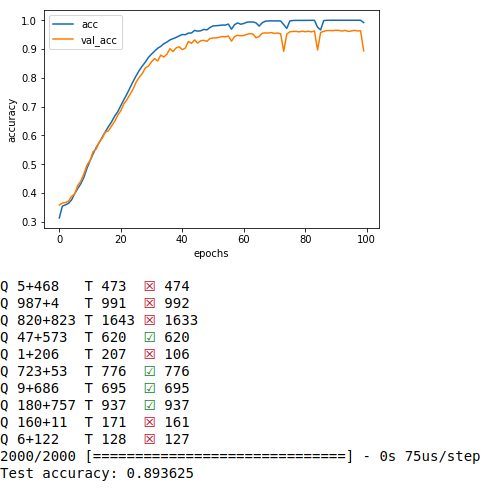|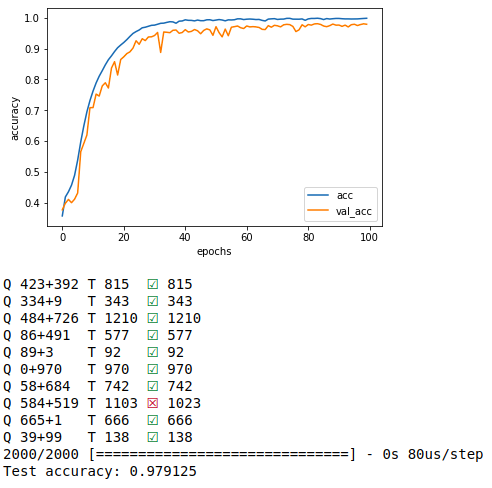|
|**Subtractor**|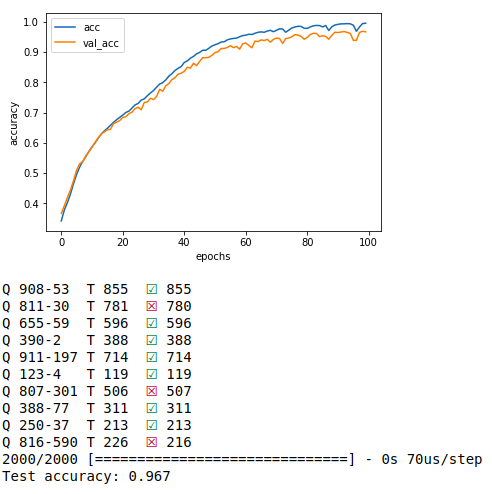|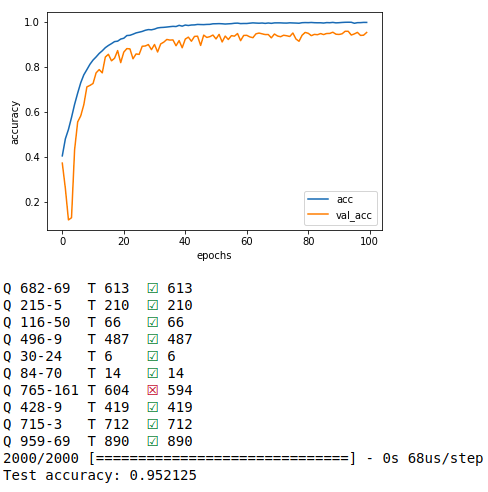|
|**Combine**|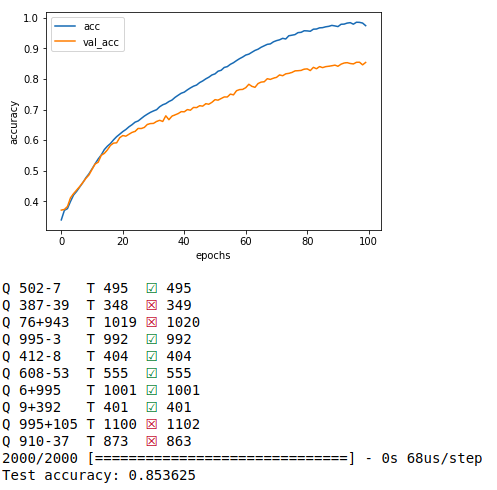|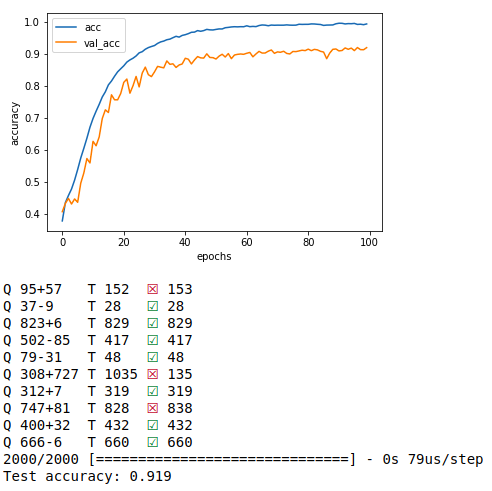|

# Training and validation functions

In [9]:
def train(model, x_train, x_val, y_train, y_val, epochs, batch_size=128, verbose=0):
    return model.fit(x_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(x_val, y_val),
                     verbose=verbose)

def plot_result(result):
    accs = ['acc', 'val_acc']
    for acc in accs:
        plt.plot(result.history[acc])
    plt.legend(accs)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    
def accuracy(model, x_val, y_val):
    return model.evaluate(x_val, y_val)[1]

def result_sampling(model, x_val, y_val, ctable, num_sample=10, reverse=False):
    for i in range(num_sample):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if reverse else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

## 1. Adder

### Config

In [10]:
chars = '0123456789+ '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
epochs = 100
hidden_size = 128
data_size = 20000

### Generate data

In [11]:
xs, ys = gen_data(data_size, '+', max_len, digits)
xs, ys = vectorization(xs, ys, ctable, max_len, digits)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Testing Data:
(2000, 7, 12)
(2000, 4, 12)


### Build model and train

In [12]:
model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars)
result = train(model, x_train, x_val, y_train, y_val, epochs)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 128)            512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 206,348
Trainable params: 205,836
Non-trainable params: 512
_____________________________________________________

### Analysis

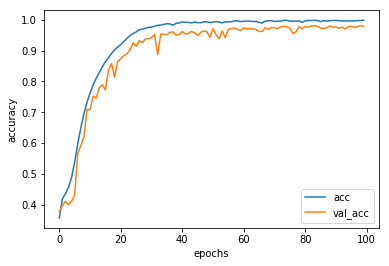

Q 423+392 T 815  ☑ 815 
Q 334+9   T 343  ☑ 343 
Q 484+726 T 1210 ☑ 1210
Q 86+491  T 577  ☑ 577 
Q 89+3    T 92   ☑ 92  
Q 0+970   T 970  ☑ 970 
Q 58+684  T 742  ☑ 742 
Q 584+519 T 1103 ☒ 1023
Q 665+1   T 666  ☑ 666 
Q 39+99   T 138  ☑ 138 
2000/2000 [==============================] - 0s 80us/step
Test accuracy: 0.979125


In [14]:
plot_result(result)
result_sampling(model, x_val, y_val, ctable)
print('Test accuracy: {}'.format(accuracy(model, x_val, y_val)))

## 2. Subtractor

### Config

In [15]:
chars = '0123456789- '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
epochs = 100
hidden_size = 128
data_size = 20000

### Generate data

In [16]:
xs, ys = gen_data(data_size, '-', max_len, digits)
xs, ys = vectorization(xs, ys, ctable, max_len, digits)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Testing Data:
(2000, 7, 12)
(2000, 4, 12)


### Build model and train

In [17]:
model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars)
result = train(model, x_train, x_val, y_train, y_val, epochs)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 128)            512       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
Total params: 206,348
Trainable params: 205,836
Non-trainable params: 512
_____________________________________________________

### Analysis

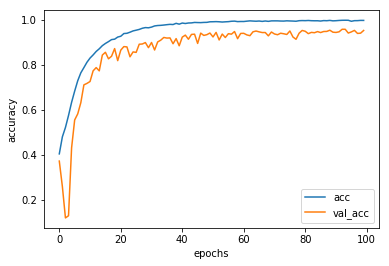

Q 682-69  T 613  ☑ 613 
Q 215-5   T 210  ☑ 210 
Q 116-50  T 66   ☑ 66  
Q 496-9   T 487  ☑ 487 
Q 30-24   T 6    ☑ 6   
Q 84-70   T 14   ☑ 14  
Q 765-161 T 604  ☒ 594 
Q 428-9   T 419  ☑ 419 
Q 715-3   T 712  ☑ 712 
Q 959-69  T 890  ☑ 890 
2000/2000 [==============================] - 0s 68us/step
Test accuracy: 0.952125


In [18]:
plot_result(result)
result_sampling(model, x_val, y_val, ctable)
print('Test accuracy: {}'.format(accuracy(model, x_val, y_val)))

## 3. Combine adder and subtractor

### Config

In [19]:
chars = '0123456789+- '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
epochs = 100
hidden_size = 128
data_size = 20000

### Generate data

In [20]:
xs_add, ys_add = gen_data(data_size//2, '+', max_len, digits)
xs_sub, ys_sub = gen_data(data_size//2, '-', max_len, digits)
xs = xs_add + xs_sub
ys = ys_add + ys_sub
xs, ys = vectorization(xs, ys, ctable, max_len, digits)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Testing Data:
(2000, 7, 13)
(2000, 4, 13)


### Build model and train

In [21]:
model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars)
result = train(model, x_train, x_val, y_train, y_val, epochs)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               72704     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 128)            512       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 13)             1677      
Total params: 206,989
Trainable params: 206,477
Non-trainable params: 512
_____________________________________________________

### Analysis

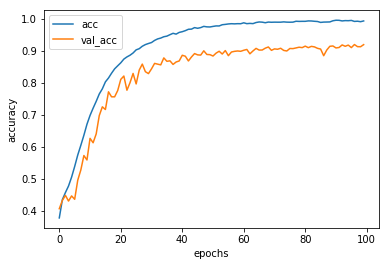

Q 95+57   T 152  ☒ 153 
Q 37-9    T 28   ☑ 28  
Q 823+6   T 829  ☑ 829 
Q 502-85  T 417  ☑ 417 
Q 79-31   T 48   ☑ 48  
Q 308+727 T 1035 ☒ 135 
Q 312+7   T 319  ☑ 319 
Q 747+81  T 828  ☒ 838 
Q 400+32  T 432  ☑ 432 
Q 666-6   T 660  ☑ 660 
2000/2000 [==============================] - 0s 79us/step
Test accuracy: 0.919


In [22]:
plot_result(result)
result_sampling(model, x_val, y_val, ctable)
print('Test accuracy: {}'.format(accuracy(model, x_val, y_val)))